# Simulating Optical Tracking Errors

In this page, we walk through an example of how to simulate the tracking errors experienced in optical tracking. 


In [19]:
%matplotlib inline

In [20]:
# Jupyter notebook sets the cwd to the folder containing the notebook.
# So, you want to add the root of the project to the sys path, so modules load correctly.
import sys
sys.path.append("../../")

In [21]:
# All other imports
import copy
import random
import numpy as np
import matplotlib.pyplot as plt
import sksurgerycore.transforms.matrix as mat
import sksurgerycore.algorithms.procrustes as pro
import sksurgerycore.algorithms.errors as err

# Understand a Tracking Marker

In these examples, we will assume the use of NDI optical markers, as these are the most common. The same principles apply to Atracsys, OptiTrak etc. 

For example, look at this NDI pointer:

![NDI marker](https://48e3urpkpt226n9pw3mm2p61-wpengine.netdna-ssl.com/wp-content/uploads/2020/09/probe.jpg)

You can use NDI software to extract the coordinates of each of the silver balls, or on the NDI support website, you can log in and download a .rom file which contains these coordinates. Each vendor will provide an accurate definition of their coordinates.

For example, the above marker has coordinates:

```
x=0.00, y=0.00, z=0.00
x=0.00, y=0.00, z=50.00
x=0.00, y=25.00, z=100.00
x=0.00, y=-25.00, z=135.00
```

Here you can see, all points lie in the x=0 plane. The first point, nearest the tip is deemed to be the origin. The z-axis is parallel to and along the length of the shaft. So the second point, is in a line along the shaft, with the 3rd and 4th points offset to the side in the y-axis. The manufacturer can define an arbitrary origin, e.g. the centroid, that doesn't have to correspond to a single ball.


# Designing a Tracking Marker

Each vendor can define their own, see for example [these by Atracsys](https://www.atracsys-measurement.com/products/passive-accessories-2/). Or, for simulation purposes, you can define your own, as we did in the ["Using FLE to calculate TRE"](https://mphy0026.readthedocs.io/en/latest/notebooks.html) workshop. 

You should read [West and Maurer 2004](http://dx.doi.org/10.1109/TMI.2004.825614), which has a very thorough explanation of the theory, and a very widely applicable simulation, and experimental verification. 


# Understanding Optical Tracking

So, the NDI Polaris Spectra optical tracker has 2 cameras, so, each camera detects an image of the silver balls, and these are then triangulated in 3D space. This was covered in the [Tracking](https://mphy0026.readthedocs.io/en/latest/tracking/optical.html) lecture. 

Triangulating the position of the silver balls, gives 3D coordinates with respect to the origin of the tracker. 

So, doing point based registration of marker coordinates to tracker coordinates gives you the rotation and translation between the coordinate systems. In other words, if you multiply the origin (0,0,0) by this rotation and translation, you find out where the origin of the marker is in the tracking coordinate system. i.e. you know where it is. 

So, the registration transformation of marker coordinates to tracker coordinates IS the tracking information you need to track to marker. 

# Understanding Tool Design

A tracking marker is normally attached to a medical device. In the case of the pointer, the pointer IS the medical device. In either case, there will be a point of interest, some distance away from the tracking marker. In the case of the pointer, its about 20cm away. In the case of a laparoscope, it could be 30-50cm away.

Take for example the pointer shown above. Imagine that the tip is 

```
x=0, y=0, z=-150
```

This tip coordinate is expressed in the same coordinate system as the balls (i.e. the marker coordinate system).

Once we know the tracking transformation, we can multiply this tip coordinate, by the tracking transformation to know where the tip of the pointer is in tracker coordinates.

Here the pointer tip is the point of interest, and when designing the tool, we could ask "what is the TRE at the tip of the pointer", in other words, "how accurately can we locate it?"

# Worked Example

So, lets do a worked example. What is the TRE for the pointer, at a reasonable distance from a tracker?


In [35]:
# Keep all units the same, in millimetres
distance_from_tracker = 1500

# Compare with above. We are encoding the marker points into a numpy mattrix
marker_points = np.zeros((4, 3))
marker_points[1][2] = 50
marker_points[2][1] = 25
marker_points[2][2] = 100
marker_points[3][1] = -25
marker_points[3][2] = 135


# This is an obvious simplification:
# Imagine that the marker is placed along the -z axis, facing exactly perpendicularly to the tracker
# In that case, the same geometry is in the X-Y plane rather than the Y-Z plane of the model coordinates
triangulated_points = np.zeros((4, 3))
triangulated_points[0][0] = 0
triangulated_points[0][1] = 0
triangulated_points[0][2] = -distance_from_tracker
triangulated_points[1][0] = 0
triangulated_points[1][1] = 50
triangulated_points[1][2] = -distance_from_tracker
triangulated_points[2][0] = 25
triangulated_points[2][1] = 100
triangulated_points[2][2] = -distance_from_tracker
triangulated_points[3][0] = -25
triangulated_points[3][1] = 135
triangulated_points[3][2] = -distance_from_tracker

# Now register the marker_points to the triangulated_points to give a starting tracking matrix
R, t, FRE = pro.orthogonal_procrustes(triangulated_points, marker_points)

# Print matrices. The rotation should look like a change of axes.
print("Rotation is:" + str(R))
print("Translation is:" + str(t))
print("FRE is:" + str(FRE))

Rotation is:[[ 1.00075302e-16  1.00000000e+00 -9.49728969e-17]
 [ 1.20982797e-16  5.04647493e-17  1.00000000e+00]
 [ 1.00000000e+00  0.00000000e+00 -1.11022302e-16]]
Translation is:[[ 6.76681890e-15]
 [ 1.42108547e-14]
 [-1.50000000e+03]]
FRE is:8.872994544127538e-15


# Where Is The Pointer?

So, given a default starting position, can we calculate the pointer tip position in tracker coordinates?

In [36]:
length_of_pointer_from_origin = 150
pointer_tip = np.zeros((1, 3))
pointer_tip[0][2] = -length_of_pointer_from_origin

pointer_in_tracker_coordinates = np.matmul(R, np.transpose(pointer_tip)) + t

print("Pointer tip is:" + str(pointer_in_tracker_coordinates))

Pointer tip is:[[ 2.10127534e-14]
 [-1.50000000e+02]
 [-1.50000000e+03]]


# Variation with Noise

Now we can analyse how the location of the tip varies, when we add tracker noise. Tracker noise can be modelled by adding Gaussian distributed noise onto each of the triangulated points, to change their position by a small amount.
Then we can re-register the model points back to the (now corrupted) triangulated points, and compute a new rotation matrix and translation vector, and re-compute the position of the pointer tip. i.e. as a result of noise, it will have moved slightly. We can then directly measure error of the tip. The RMS of these errors is the TRE.

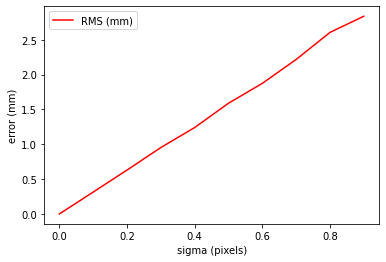

In [37]:
number_samples = 2000
x_values = []
y_values = []
for sigma_counter in range(0, 10, 1):
    sigma = sigma_counter / 10
    rms = 0
    corrupted_points = copy.deepcopy(triangulated_points)
    for i in range(number_samples):
        
        # Create corrupted tracking points
        for r in range(0, 4):
            for c in range(0, 3):
                corrupted_points[r][c] = triangulated_points[r][c] + random.normalvariate(0, sigma)
        
        # Compute a new R, t, FRE
        R, t, FRE = pro.orthogonal_procrustes(corrupted_points, marker_points)
        
        # Copute new tip position
        tip_position = np.matmul(R, np.transpose(pointer_tip)) + t
        
        # Calculate error
        diff = np.linalg.norm(tip_position - pointer_in_tracker_coordinates)
        diff = diff * diff
        rms = rms + diff
        
    rms = rms / number_samples
    rms = np.sqrt(rms)
    x_values.append(sigma)
    y_values.append(rms)
    
plt.plot(x_values, y_values, 'r', label='RMS (mm)')  
plt.legend(loc='upper left')
plt.xlabel('sigma (pixels)')
plt.ylabel('error (mm)')
plt.show()        

# Discussion

So, in the above plot, we see that with sigma=0.25 (quoted accuracy of NDI Polaris Spectra), we could expect a RMS error, with a 150mm pointer, of about 0.8mm.

Try it with a longer pointer. What if the length of the pointer were 500mm? 